Bayesian hypothesis testing is an alternative to traditional frequentist A/B testing that allows a experimenter to form beliefs and make informed decisions throughout an experiment, from the moment the first data point is collected, rather than waiting for some pre-determined sample size for statistical significance (defined at some threshhold of tolerance for Type I and Type II error) before forming or acting on any beliefs. This may be especially useful for companies who can't reliably wait for sufficient sample sizes before making decisions, whether because user volumes or budgets are too limited, or simply due to impatience and a desire to act on intuitions 



### Frequentist A/B testing  ###

"I have no prior beliefs about the world. Let's run an A/B test and randomly split users between landing page A vs. B, and keep splitting them evenly throughout the experiment. Don't look at the results or act on them until the experiment is over. We can conclude nothing at all until we have sufficient sample size. If we end up not collecting enough data, the experiment was useless."

### Bayesian A/B testing###

"I'll start with a best guess about landing page A vs. B; I accept the risk of incorporating my biases into the analysis via this prior belief. Every time someone visits the site and clicks or doesn't, I'll update my best guess to be more specific. This way I'll have a constantly updating view ("posterior") of how good the click-through rate on the landing page is. More data makes me more certain, but even from day one I can start directing more traffic to the landing page that's performing better so far, e.g. with a [Multi-Armed ](https://support.google.com/analytics/answer/2844870?hl=en) [bandit algorithm](http://stevehanov.ca/blog/index.php?id=132)."

### Examining the Bayesian approach 

Starting with a prior probability distribution for the parameter in question (click-through rate) - whether uniform or more opinionated - we can iteratively apply Bayes' rule as data is collected to continually update our belief about the click-through rates for each version.

In Bayes' theorem below, let's define $\theta$ as click-through rate (i.e. probability of success for each Bernoulli trial) and $Y$ as a pattern of 0s and 1s representing whether users did or did not click on the call-to-action during each Bernoulli trial (site visit). 

$$\Pr(\theta \mid Y) = \frac{\Pr(Y \mid \theta)\cdot\Pr(\theta)}{\Pr(Y)}$$

This notebook is based on an exercise in [Galvanize](http://www.galvanize.com/san-francisco)'s data science and machine learning immersive program.

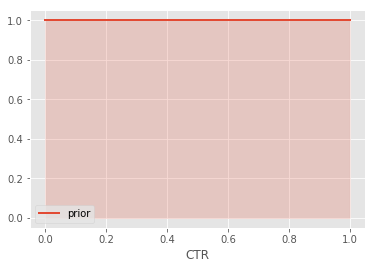

In [1]:
'''
Setup, import data
'''
%matplotlib inline
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import click data for each landing page (1 if user clicked the call-to-action, 0 if not)
a,b = np.loadtxt('data/siteA.txt'), np.loadtxt('data/siteB.txt')

# initialize a uniform prior with equal probabilities of CTRs between 0% and 100%
x = np.arange(0,1.001,0.001)

# beta distribution w/ alpha, beta = 1 is a uniform distribution
alpha_0, beta_0 = 1,1
y_prior = scs.beta.pdf(x, alpha_0, beta_0)

# plot the distribution
def plot_distrib(x,y,label):
    lines = plt.plot(x,y,label=label, lw=2)
    plt.fill_between(x,0,y,alpha=0.2, color=lines[0].get_c())
    plt.legend()
    
plot_distrib(x,y_prior,'prior')
plt.xlabel('CTR')

plt.show()

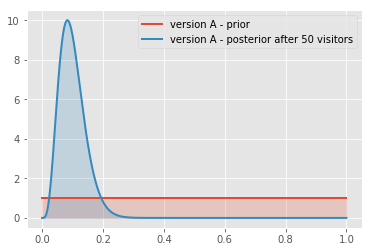

In [2]:
''' 
Use a beta distribution to update posterior after observing some data. 

alpha = 1+num_successes = 1+k
beta = 1+num_failures = 1+n-k
'''

def get_pdf(x,data):
    alpha = sum(data) 
    beta = len(data) - alpha 
    return scs.beta(a=alpha, b=beta).pdf(x)

# graph posterior after 50 visits

plot_distrib(x,y_prior,'version A - prior')
plot_distrib(x,get_pdf(x,a[:50]),'version A - posterior after 50 visitors')


As we observe the click patterns of more and more site visitors, our belief about the click-through rate of site A gets more and more peaky and specific. 

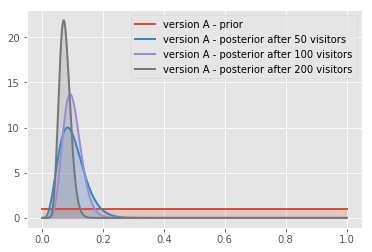

In [3]:
# graph posterior after 20, 50, 100, and 200 visits

plot_distrib(x,y_prior,'version A - prior')
plot_distrib(x,get_pdf(x,a[:50]),'version A - posterior after 50 visitors')
plot_distrib(x,get_pdf(x,a[:100]),'version A - posterior after 100 visitors')
plot_distrib(x,get_pdf(x,a[:200]),'version A - posterior after 200 visitors')

Now, let's figure out the probability that site B is better than site A using a simulation. Since these are probability density functions, they can be interpreted as expressing the relative probabilities of any specific value of the CTR being the "true" CTR, with the area under the pdf summing to 1.

We can run a simulation using these probability distributions and draw 10,000 samples, keeping a count of the number of times site B's click-through rate was higher than site A's click-through rate. 

probability that version B is better than version A, given the observed data: 0.995

probability that version B's CTR is 5% better than version A's CTR, given the observed data: 0.1638


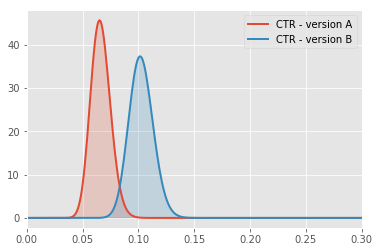

In [4]:
# visualize the probability density functions of CTR for both landing pages
plot_distrib(x,get_pdf(x,a[:800]),'CTR - version A')
plot_distrib(x,get_pdf(x,b[:800]),'CTR - version B')
plt.xlim(0,.3)

# draw 10,000 samples and see how many had a higher CTR for B than A
sample_a = np.random.beta(a=sum(a), b=len(a)-sum(a), size=10000)
sample_b = np.random.beta(a=sum(b), b=len(b)-sum(b), size=10000)

print 'probability that version B is better than version A, given the observed data:',(sample_b > sample_a).mean()

# We can also assess the probability that version B is X% better than version A.

print '\nprobability that version B\'s CTR is 5% better than version A\'s CTR, given the observed data:',(sample_b > sample_a+.05).mean()

This makes it very clear what kind of conclusions we can draw from the observed data. We can be fairly certain that version B has a higher CTR than version A, but it's quite unlikely that version B's CTR is at least 5% higher.

Let's see how this compares to the frequentist approach of specifying a null hypothesis and running a t-test to see if we can reject the null at a given significance level:

In [5]:
t_stat, p_val = scs.ttest_ind(a,b)

print 'The null hypothesis is that there is no difference in the CTRs of site A and B.'

print 'The p-value is: ', p_val

The null hypothesis is that there is no difference in the CTRs of site A and B.
The p-value is:  0.00907734525729


Therefore, we can reject the null hypothesis and conclude that there is indeed a difference in the CTRs. But what if we only consider the first 50, 100, or 200 data points?

In [7]:
t_stat, p_val_50 = scs.ttest_ind(a[:50],b[:50])
t_stat, p_val_100 = scs.ttest_ind(a[:100],b[:100])
t_stat, p_val_200 = scs.ttest_ind(a[:200],b[:200])

print 'p-value with first 50 site visits: ', p_val_50
print 'p-value with first 100 site visits: ', p_val_100
print 'p-value with first 200 site visits: ', p_val_200


 p-value with first 50 site visits:  0.466042072594
p-value with first 100 site visits:  0.810592053415
p-value with first 200 site visits:  0.586715666785


Note that with traditional frequentist methods, we would likely conclude that the p-value is too high to reject the null and take no further action, whereas with Bayesian methods we can articulate our best guess about the relative CTR of each landing page at each of these points in time (after observing 50, 100, and 200 site visits). 

Multi-armed bandit algorithms take advantage of this by diverting relatively more traffic to the current winner at every time step, while still continuing to divert some traffic to all variations for ongoing data collection. This minimizes the total amount of traffic sent to the likely "loser" while still achieving the objective of picking a winner with a high level of confidence by the end of the experiment. 